# Installs

For the purpose of completing this notebook, I created a virtual environment (aka venv). Python virtual environments are used to create an isolated environment for Python projects. Each project can have its own Python version and its own dependencies, regardless of what dependencies every other project has. In this case, in my new venv I installed tensorflow (using `conda install -c conda-forge tensorflow` from the terminal after creating and activating the venv), keras, matplotlib, mlflow, and others. Instructions to easily create a venv in a Vertex Workbench notebook [here](https://medium.com/google-cloud/upgrade-google-vertex-ai-workbench-notebook-python-version-64ee1d8b4a9).

In [55]:
!pip3 install --upgrade --q google-cloud-aiplatform

# Imports

In [56]:
import tensorflow
from numpy.random import seed

seed(888)
tensorflow.random.set_seed(404)

In [57]:
import os
import numpy as np
import tensorflow as tf
import itertools

from time import strftime

from google.cloud import aiplatform as vertexai
import mlflow

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [123]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
TRAINING_SIZE = 40000
SMALL_TRAIN_SIZE = 1000

# For autologging the experiment with Tensorboard:
PROJECT_ID = 'testing-elena'
REGION = 'us-central1'
BUCKET_URI = 'gs://experiments-workshop'
AUTOLOGGED_EXPERIMENT_NAME = "cifar10-tf-experiment"
EXP_TENSORBOARD = "projects/1080686785400/locations/us-central1/tensorboards/8684831241570091008"

# Get the Data

In [59]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [60]:
type(cifar10)

module

In [61]:
type(x_train_all)

numpy.ndarray

# Explore the Data

In [62]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

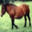

In [63]:
pic = array_to_img(x_train_all[7])
display(pic)

In [64]:
y_train_all.shape

(50000, 1)

In [65]:
y_train_all[7][0]

7

In [66]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

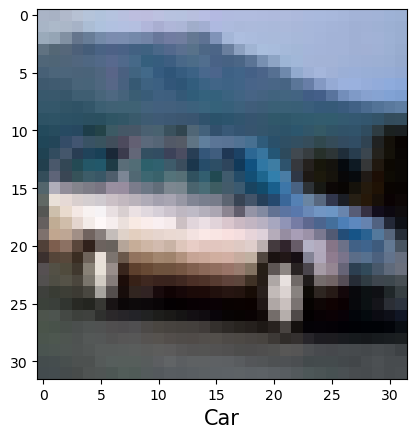

In [67]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

**Challenge**: Write a for loop to display the first 10 images from the `x_train_all` array in a row. Show the name of the label below the picture. Remove the ugly tick marks. Hint use matplotlib.

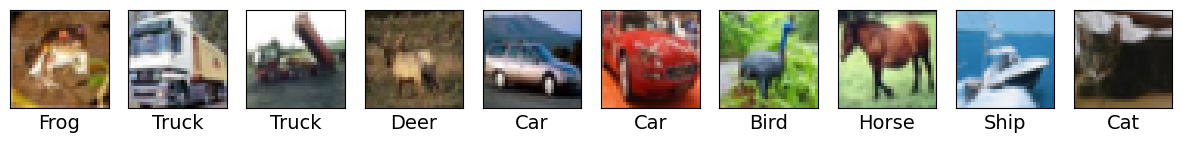

In [68]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_all[i])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
    plt.xticks([]) # Remove X ticks
    plt.yticks([]) # Remove Y ticks

plt.show()

In [69]:
x_train_all[0].shape # see images dimensions

(32, 32, 3)

In [70]:
nr_images, x, y, c = x_train_all.shape
print(f'training images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

training images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [71]:
x_test.shape

(10000, 32, 32, 3)

We see  that we have 50,000 training images and 10,000 testing ones. We also know that each image is 32x32 pixels, and that each pixel has 3 channels (corresponding to RGB).

# Preprocess Data

In [72]:
type(x_train_all[0][0][0][0])

numpy.uint8

All these (pixel) values are of type uint (unsigned integer, i.e. a positive number), and between 0 and 255. Thinking about later calculations for our model (e.g. loss function, weights adjustment) using the learning rate, which is a really low value, it will be more convenient to make these numbers smaller. Let's divide everything by 255, having a float between 0 and 1 for each RBG value (instead of between 0 and 255).


In [73]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [74]:
type(x_train_all[0][0][0][0])

numpy.float64

Now, we want to flatten out our dataset. Instead of having 4 dimensions, it would be more convenient to have a single vector, a single row of values, to have the three dimensions of one single image. We do this using [.reshape(array_to_be_reshaped, new_shape)](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). We will reshape the x_train_all[0] subarray from x_train_all.

In [75]:
x_train_all.shape

(50000, 32, 32, 3)

In [76]:
x_train_all[0].shape # Single image shape

(32, 32, 3)

In [77]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS) # TOTAL_INPUTS defined in our constants: IMAGE_WIDTH * IMAGE_HEIGHT * COLOR_CHANNELS

In [78]:
x_train_all.shape

(50000, 3072)

In [79]:
x_test.shape

(10000, 32, 32, 3)

In [80]:
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


# Create Validation Dataset

As our test dataset is already the 20% of the training one, we will use other 20% (other 10,000 examples) for the validation dataset. Then store the remaining training dataset as our final training dataset.

In [81]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_val.shape

(10000, 3072)

**Challenge:** Create two numpy arrays x_train and y_train that have the shape (40000, 3072) and (40000, 1) respectively. They need to contain the last 40000 values from x_train_all and y_train_all respectively.

In [82]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

x_train.shape

(40000, 3072)

**Note:** In order to accelerate the training process, it's common to create a small training dataset, e.g. `x_train_xs` and `y_train_xs` only for this testing phase, and then once we're happy with the result and our EDA process, we use our bigger training dataset again. We won't do it in this case.

# Define  & Compile the Neural Network using Keras

Code to create our perceptron:

In [83]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'), # First hidden layer
    Dense(units=64, activation='relu', name='m1_hidden2'), # Second hidden layer, Keras will take the input_dim from the previous cell (128)
    Dense(units=16, activation='relu', name='m1_hidden3'), # Third hidden layer,
    Dense(units=10, activation='softmax', name='m1_output'), # Output layer using softmax, 10 classes for our images classification
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The `Sequential()` function creates a sequential model in Keras. A sequential model is a linear stack of layers, where each layer has exactly one input tensor and one output tensor. This makes it a good choice for simple models with a linear topology.

In [84]:
type(model_1)

keras.engine.sequential.Sequential

In [85]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


Where does the total number of parameters come from? The number of connections are the number of weights to be calculated. But that are not the only parameters, we also have the bias and the activation functions, which will determine how strong each neuron will fire. When changing the weights, what we're really changing is the activation function, making it more or less steep. When defining a bias, we're really moving the activation function horizontally or vertically.

In [86]:
print('number of connection weights in the input layer =', 32*32*3*128)

number of connection weights in the input layer = 393216


In [87]:
print("But each neuron doesn't have just weights, it also has bias terms, so there we have", 128, "parameters more. So in total, we have 393216+128=", 393216+128, "parameters for the first hiden layer.")

But each neuron doesn't have just weights, it also has bias terms, so there we have 128 parameters more. So in total, we have 393216+128= 393344 parameters for the first hiden layer.


Now we need to do that for each layer in the NN, so in total:

In [88]:
print("Total parameters = 32*32*3*128+128 + 128*64+64 + 64*16 + 16 + 16*10+10 =", 32*32*3*128+128 + 128*64+64 + 64*16 + 16 + 16*10+10 )

Total parameters = 32*32*3*128+128 + 128*64+64 + 64*16 + 16 + 16*10+10 = 402810


# Tensorboard (visualising learning)

Tensorboard will use a series of files. We'll put all that files in a folder in this directory: `tensorboard_cifar_logs` (added a constant `LOG_DIR` for this). A couple of imports were used: `os`, `TensorBoard`, `strftime`.

In [89]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H:%M")}' # folder name creation including current timestamp as a name

    dir_paths = os.path.join(LOG_DIR, folder_name)

    # Python error handling:
    try:
        os.makedirs(dir_paths) # making the directory
    except OSError as err:
        print(err.strerror) # convert our error to a string, allowing us to print it out
    else:
        print('Successfully created directory', folder_name)

    return TensorBoard(log_dir = dir_paths)

# Fit the model
We'll use the [fit method](https://keras.io/api/models/model_training_apis/#fit-method) with some small datasets for doing training tests.

#### Create a small dataset (for Illustration)

In [90]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

Now for logging results to a TensorBoard, we need to open up a terminal and run:

#### Create an experiment for tracking training parameters and metrics

Because some model types like TensorFlow result in autologging time series metrics, we'll create a TensorBoard instance:

**NOTE**: As I'm not working locally but in GCP, I already created an experiment in order to visualise the TensorBoard.

Let's now initiate a Vertex experiment using the init() method:

In [91]:
vertexai.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=BUCKET_URI,
    experiment=AUTOLOGGED_EXPERIMENT_NAME,
    experiment_tensorboard=EXP_TENSORBOARD,
    experiment_description="autolog-tf-experiment-with-automatic-run",
)

We'll enable Vertex autologging now. After calling vertex_ai.autolog(), any metrics and parameters from model training calls with supported ML frameworks (including TF) will be automatically logged to Vertex Experiments.

In [92]:
vertexai.autolog()

#### Fit the model

We'll also use Tensorboard as a callback. [Callbacks](https://keras.io/api/callbacks/base_callback/#callback-class) can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

Epoch: When our entire dataset is passed through the NN at a single time. If we only have 1 epoch, then we’ll see just 1 epoch in our Tensorboard. As the loss function is an iterative process, we need to pass the entire dataset many times through our NN (this is, have several epochs) in order that our model gets improved using the loss function. Otherwise, we can split our dataset in batches, and train in on one batch at a time, taking multiple iterations in each batch. 

_Number of iterations for completing one epoch = Nr of Training Samples / Batch Size_

In [93]:
samples_per_batch = 1000

In [94]:
%%time
nr_epochs = 150
model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 1')], verbose=0) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 1 at 08:11
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-11-58-dfd5b to Experiment: cifar10-tf-experiment
CPU times: user 13.5 s, sys: 352 ms, total: 13.9 s
Wall time: 20.7 s


**NOTE 1:** We should expect the accuracy to improve towards the last epoch. If that doesn't happen, we might need to re-compile our model and rerun the training.

**NOTE 2:** If in tensorboard we see that each training iteration is starting from the point where the last one finished, it means that the model is being saved on disk and being picked from there, so basically it's remembering how the model behaved with the weights from the previous run. If we want all iterations to start at the same point (which makes sense for comparing), then we should recompile our model before rerunning it.



Now, let's see how the model behaves with new data, with the validation dataset.

In [95]:
%%time
nr_epochs = 150
model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 1')], verbose=0, validation_data=(x_val, y_val)) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 1 at 08:12
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-12-19-55fad to Experiment: cifar10-tf-experiment
CPU times: user 1min 6s, sys: 2.05 s, total: 1min 8s
Wall time: 40.8 s


# Avoiding Overfitting - Regularisation, Early Stopping, and Dropout

Overfitting happens when the model learns your training data too well. Consequence of overfitting: poor performance with validation and other new datasets. Consequence of underfitting: not learning the patterns correctly.

In [159]:
![Overfitting](https://www.mathworks.com/discovery/overfitting/_jcr_content/mainParsys/image.adapt.full.medium.svg/1686825007300.svg)

/bin/bash: -c: line 1: syntax error near unexpected token `https://www.mathworks.com/discovery/overfitting/_jcr_content/mainParsys/image.adapt.full.medium.svg/1686825007300.svg'
/bin/bash: -c: line 1: `[Overfitting](https://www.mathworks.com/discovery/overfitting/_jcr_content/mainParsys/image.adapt.full.medium.svg/1686825007300.svg)'


There are different techniques to avoid overfitting:
- Regularisation: A simple solution fits better than a complex one. 
- Early stopping: If validation accuracy isn’t improving, and if validation loss or error is no longer decreasing, then less stop training.
- Dropout: If you ignore some randomly chosen neurons during training, this can help also

We'll start by trying a dropout technique. Instead of defining a new model like we did before, let's use the [sequential model .add()](https://keras.io/guides/sequential_model/) method to learn a different approach. Let's compare it with the other coding approach, rembering how we created our model 1:

```
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'), 
    Dense(units=16, activation='relu', name='m1_hidden3'),
    Dense(units=10, activation='softmax', name='m1_output'),
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
```

The only change is that we'll also add a dropout technique here:

In [96]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,))) # droput value is usually 20%-50%
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))
 

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
%%time
nr_epochs = 150
model_2.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 2')], verbose=0, validation_data=(x_val, y_val)) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 2 at 08:13
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-13-00-06521 to Experiment: cifar10-tf-experiment
CPU times: user 1min 11s, sys: 1.88 s, total: 1min 13s
Wall time: 42.2 s


Looking at the Tensorboard results, we see that there's an improvement: the loss function is in general lower, and it also goes up less drastically than before. But it still goes a bit up at the end, so let's try to use dropout in combination with early stopping to see if the results improve!

**Challenge:** Create a model_3 that has 2 dropout layers. The second dropout layer should be added after the first hidden layer and have a dropout rate of 25%.

In [98]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.25, seed=42)) # Input shape is automatically inferred by Keras
model_3.add(Dense(64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m2_output'))
 

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Let's now train our model with our whole dataset, not just with the small version of it. Let's compare 1 (no dropout), model 2 (1 dropout), and model 3 (2 dropouts) with this bigger dataset.

In [99]:
%%time
nr_epochs = 100
model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 1 XL')], verbose=0, validation_data=(x_val, y_val)) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 1 XL at 08:13
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-13-42-013be to Experiment: cifar10-tf-experiment
CPU times: user 5min 37s, sys: 9.14 s, total: 5min 46s
Wall time: 1min 58s


In [100]:
%%time
nr_epochs = 100
model_2.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 2 XL')], verbose=0, validation_data=(x_val, y_val)) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 2 XL at 08:15
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-15-40-c853c to Experiment: cifar10-tf-experiment
CPU times: user 8min 5s, sys: 11.6 s, total: 8min 16s
Wall time: 2min 39s


In [101]:
%%time
nr_epochs = 100
model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 3 XL')], verbose=0, validation_data=(x_val, y_val)) # verbose=0 clears epochs and accuracy from our output

Successfully created directory Model 3 XL at 08:18
Associating projects/1080686785400/locations/us-central1/metadataStores/default/contexts/cifar10-tf-experiment-tensorflow-2023-09-03-08-18-20-dd156 to Experiment: cifar10-tf-experiment
CPU times: user 8min 16s, sys: 11 s, total: 8min 27s
Wall time: 2min 44s


**Conclusion**
- When going from 1,000 examples to 40,000 examples, the accuracy went much better. Specifically:
    - Model 2XL and expecially Model 3XL, the one with more amount of dropout, were the ones that learned the training data most slowly 
    - Seeing the accuracy in the validation dataset, we will see that the difference is much higher between the models with small amount of training data and the ones with a larger training datet.
    - Still, we see that the loss of Model 1 XL comes back to increase at the end, so we should include some early stopping to reduce this overfitting. M2XL and M3XL seem to have a bit worse results, but we see their loss doesn't increase, which is a sign that they are overfitting less than M1XL
  
- In general, models trained with dropout take longer to train, but should give better accuracy in cases with overfitting (maybe we need to use it in combination with early stopping, though)


# Predictions on individual images

In [102]:
x_val.shape

(10000, 3072)

We have 10,000 images, and 3072 corresponds to all pixels of an image. Let's explore the first image:

In [103]:
x_val[0]

array([0.231, 0.243, 0.247, ..., 0.482, 0.361, 0.282])

Let's convert this image from flattened to multi-dimensional, adding 1 extra dimension, so that we can use it individually for predictions (the model expects a 2D array):

In [104]:
test_img = np.expand_dims(x_val[0], axis=0)
test_img.shape

(1, 3072)

In [105]:
np.set_printoptions(precision=3) # formatting for just having 3 decimals
model_2.predict(test_img)

1/1 [==============================] - 0s 54ms/step


array([[1.015e-02, 1.738e-03, 7.687e-02, 9.415e-02, 8.025e-02, 5.540e-02,
        6.348e-01, 4.407e-02, 1.579e-04, 2.463e-03]], dtype=float32)

These are the probabilities that our image is of each class. We see the 7th class is the most probable. Doing it more programatically:

In [106]:
np.argmax(model_2.predict(test_img), axis=1)

1/1 [==============================] - 0s 20ms/step


array([6])

In [107]:
y_val[0] # labels for evaluation dataset

array([6], dtype=uint8)

**Challenge:** Write a for loop where you print out the actual value and predicted value for the first 10 images in the validation dataset

In [108]:
for i in range(10):
    test_img = np.expand_dims(x_val[i], axis=0)
    predicted_val = np.argmax(model_2.predict(test_img, verbose=0), axis=1)[0]
    print(f'Actual value: {y_val[i][0]} vs. predicted: {predicted_val}')

Actual value: 6 vs. predicted: 6
Actual value: 9 vs. predicted: 1
Actual value: 9 vs. predicted: 9
Actual value: 4 vs. predicted: 4
Actual value: 1 vs. predicted: 0
Actual value: 1 vs. predicted: 9
Actual value: 2 vs. predicted: 2
Actual value: 7 vs. predicted: 7
Actual value: 8 vs. predicted: 8
Actual value: 3 vs. predicted: 9


# Evaluation

Our most accurate model at the evaluation dataset was model 2. Let's confirm the two metrics we calculated in the Tensorboard:

In [109]:
model_2.metrics_names

['loss', 'accuracy']

Now, we'll use Keras [evaluate() method](https://keras.io/api/models/model_training_apis/#evaluate-method). This method returns the loss value & metrics values for the model in test mode..

In [111]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}') # formatting with :

313/313 [==============================] - 1s 2ms/step - loss: 1.4440 - accuracy: 0.4886
Test loss is 1.44 and test accuracy is 48.9%


## Confusion Matrix

In [115]:
predictions = np.argmax(model_2.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

313/313 [==============================] - 1s 2ms/step


In [116]:
conf_matrix.shape

(10, 10)

In [117]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]
print(f'Our confusion matrix has {nr_rows} rows and {nr_cols} columns')

Our confusion matrix has 10 rows and 10 columns


In [118]:
print(f'Its max value is {conf_matrix.max()} and its min value is {conf_matrix.min()}')

Its max value is 701 and its min value is 3


In [129]:
print(f'Taking a look at the values of the first row of our Conf Matrix: {conf_matrix[0]}')

Taking a look at the values of the first row of our Conf Matrix: [658  21  71  19  26   3  14  16 153  19]


<function matplotlib.pyplot.show(close=None, block=None)>

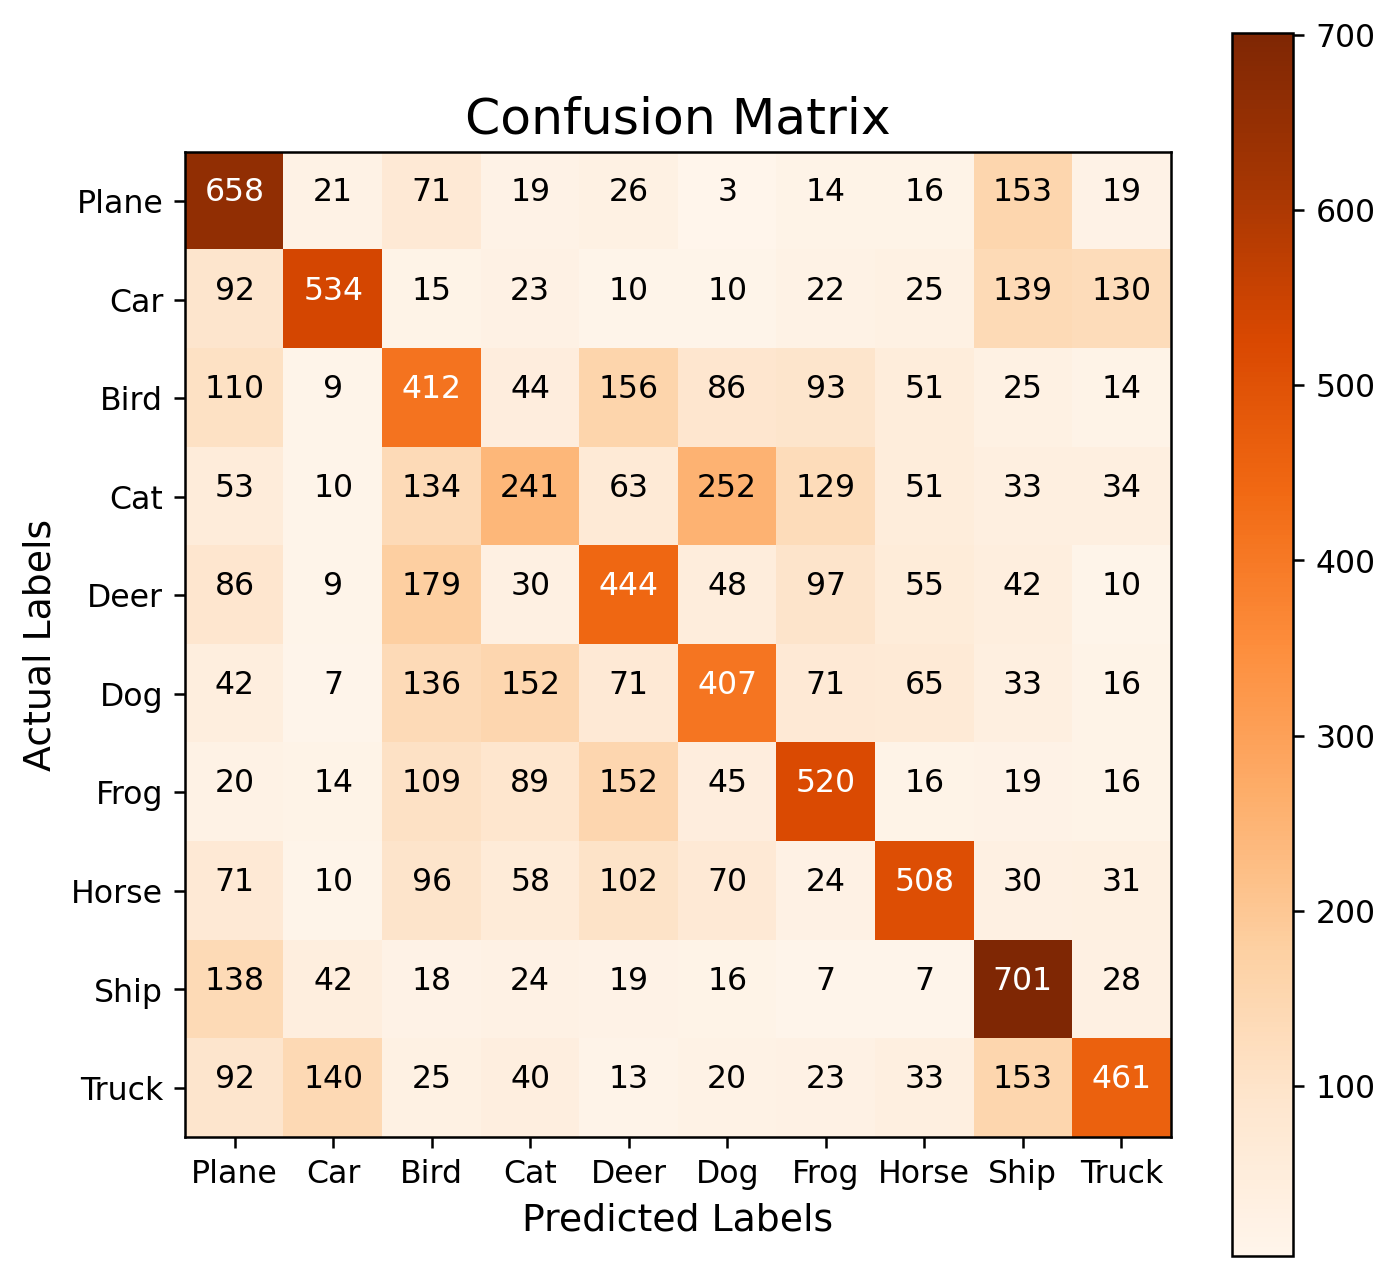

In [138]:
plt.figure(figsize=(7,7), dpi=227) # dpi scales to higher revolution
plt.imshow(conf_matrix, cmap=plt.cm.Oranges)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize = 12)
plt.xlabel('Predicted Labels', fontsize = 12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)): # range - we're starting at 0, until 9
    plt.text(j, i, conf_matrix[i, j], # Note that (x,y) coordenates imply j, i (columns, rows)
            horizontalalignment='center', # center numbers in the cells
            color = 'white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black') # set a white color for numbers in dark cells

plt.show

**NOTE - Visualisation tip:** For Confusion Matrixes, the Matplotlib colourmaps that work the best are the [sequential](https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential) ones. The darker the colours are, the higher the value is. So we see that ship images are the ones getting better predictions.

To print the individual values of this confusion matrix, we created a nested for loop. For this, we used [`itertools`](https://docs.python.org/3/library/itertools.html), python functions that create iterators for computationally efficient looping.

**Challenge:** What do numbers down the diagonal represent? What do the other numbers (excluding the diagonal ones) in a single row represent? Try to identify false positives, false negatives, and true positives in the confusion matrix.
- True positives: Values along the diagonal.
- False positives: Columns (apart from diagonal). E.g. 'Plane' column (except diagonal) shows all images that were predicted as planes, but that were not actually a plane.
- False negatives: Rows (apart from diagonal). E.g. 'Car' row (except diagonal) shows all images that were actually a car, but that were not classified as a car.

Now, we're able to calculate our **precision** and **recall** scores:

$$Recall = \frac{True Positives}{True Positives + False Negatives} $$

$$Precision = \frac{True Positives}{True Positives + False Positives} $$

In [140]:
true_positives = np.diag(conf_matrix)
true_positives

array([658, 534, 412, 241, 444, 407, 520, 508, 701, 461])

In [143]:
recall = true_positives / np.sum(conf_matrix, axis=1)
recall # We'll have one recall score for each category

array([0.658, 0.534, 0.412, 0.241, 0.444, 0.407, 0.52 , 0.508, 0.701,
       0.461])

In [145]:
precision = true_positives / np.sum(conf_matrix, axis=0)
precision # We'll have one precision score for each category

array([0.483, 0.671, 0.345, 0.335, 0.42 , 0.425, 0.52 , 0.614, 0.528,
       0.607])

Average numbers will give us the precision and recall of the model overall:

In [146]:
avg_recall = np.mean(recall)
avg_precision = np.mean(precision)
print(f'Model 2 recall score is {avg_recall:.2%} and its precision is {avg_precision:.2%}')

Model 2 recall score is 48.86% and its precision is 49.49%


Now, let's calculate the **F1 score**. F1 also measures our models accuracy, but it is still able to measure performance objetively when the class balance is skewed (as opposed to accuracy).
$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}  = \frac{TP}{TP + \frac{1}{2}(FP+FN)} $$

In [149]:
f1_score = 2 * (avg_recall * avg_precision) / (avg_recall + avg_precision)
print(f'Model 2 F1 score is {f1_score:.2%}')

Model 2 F1 score is 49.17%


Why is our error still so high? We're using all our data right now. That's right, but we're using a multilayer perceptron, which is a quite simple model. We might improve performance using a more complex model like [Inception-Resnet-v2](https://es.mathworks.com/help/deeplearning/ref/inceptionresnetv2.html) or others. However, this perceptron works great for many other cases, so it's worthy to always give it a try.